<a href="https://colab.research.google.com/github/jbastianrj/Time-Series-Forecasting-using-Transformers/blob/main/EJEMPLOS_W_transformer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# W - transformer

In [24]:
# Validar información del dispositivo

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Fri Dec  1 22:32:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    33W /  70W |    145MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Instalación de librerías

In [1]:
# Librería para la manipulación sencilla y predicción de series temporales
! pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 814.3/814.3 kB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 42.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 19.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 53.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.9/110.9 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 776.9/776.9 kB 67.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 13.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 806.1/806.1 kB 73.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 279.8/279.8 kB 32.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.4/60.4 kB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.2/169.2

### Clonación del repositorio de Git

In [2]:
%cd /content/
!git clone https://github.com/pistonly/modwtpy.git
%cd modwtpy
!wget https://raw.githubusercontent.com/pistonly/modwtpy/master/modwt.py
%cd /content

/content
Cloning into 'modwtpy'...
remote: Enumerating objects: 39, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 39 (delta 7), reused 13 (delta 3), pack-reused 17
Receiving objects: 100% (39/39), 57.50 KiB | 1.34 MiB/s, done.
Resolving deltas: 100% (10/10), done.
/content/modwtpy
--2023-12-01 22:08:37--  https://raw.githubusercontent.com/pistonly/modwtpy/master/modwt.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3966 (3.9K) [text/plain]
Saving to: ‘modwt.py.1’

modwt.py.1          100%[===================>]   3.87K  --.-KB/s    in 0s      

2023-12-01 22:08:37 (37.7 MB/s) - ‘modwt.py.1’ saved [3966/3966]

/content


### Carga de librerías

In [3]:
from pytorch_lightning.callbacks.progress import ProgressBar


In [4]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd
import time

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt

# Tratamiento de series de tiempo
# ==============================================================================
from darts import TimeSeries
from darts.metrics import mape, mase, rmse,mae,smape


# Transformaciones de datos
# ==============================================================================
from modwtpy.modwt import modwt, imodwt    # Maximal overlap discrete wavelet transform

# Algoritmos de aprendizaje
# ==============================================================================
from darts.models import (
    # Transformer
    TransformerModel,
)

# Directorio
# ==============================================================================
import os

path = 'content'
%cd /content

/content


### Función del W-transfomer

In [19]:
def w_transformer(df, nforecast = 26):
    start_time = time.perf_counter()
    series = df['Series']
    ncomp = int(np.log(len(series)))  # Número de componentes
    wt = modwt(series, 'haar', ncomp )  # Retorna las señales obtenidas mediante maximal overlap discrete wavelet transform (MODWT)

    # Inicialización
    seriesList = []
    train = []
    test = []
    nb_time = len(series) # Número total de elementos de la serie
    nb_test = int(nb_time*0.2) # Número de elementos de prueba

    # Para cada señal:
    for i in range(len(wt)):
        wt_df = TimeSeries.from_dataframe(pd.DataFrame(wt[i]))
        seriesList.append(wt_df)
        wt_df_train = wt_df[:nb_time-nforecast]
        train.append(wt_df_train)
        wt_df_test = wt_df[nb_time-nforecast:]
        test.append(wt_df_test)

    prediction = []
    # A cada componente se le ajusta un transformer y se estiman las predicciones
    for i in range(len(train)):
        transformers = TransformerModel(
                input_chunk_length=12,
                output_chunk_length=1,
                batch_size=32,
                n_epochs=200,
                model_name="transformer"+str(i),
                nr_epochs_val_period=10,
                #d_model=16,
                #nhead=8,
                d_model=64,
                nhead=32,
                num_encoder_layers=2,
                num_decoder_layers=2,
                dim_feedforward=128,
                dropout=0.1,
                activation="relu",
                random_state=42,
                save_checkpoints=True,
                force_reset=True,
                pl_trainer_kwargs = {"accelerator": "gpu"}
        )

        # Entrenamiento del transformer
        transformers.fit(series = train[i], verbose=True)
        #print('seriesList = ',seriesList[i])
        #print('nb-time-nforecast = ',nb_time-nforecast)


        # Predicción histórica del transformer
        pred_series = transformers.historical_forecasts(seriesList[i],
                                                                start = nb_time-nforecast,
                                                                retrain=False,
                                                                verbose=True,
                                                                )
        prediction.append(pred_series)

    # Se guarda en un data frame las predicciones de todas las componentes
    prediction_tmp = prediction[0].pd_dataframe()
    for i in range(1,len(prediction)):
        prediction_tmp[i] = prediction[i].pd_dataframe()
    # Se aplica la inversa de la transformada para obtener a partir de las componentes la predicción
    res = imodwt(prediction_tmp.transpose().to_numpy(),'haar')
    index_train =df.index[:nb_time-nforecast]
    index = df.index[nb_time-nforecast:]
    train_reindex = pd.DataFrame(series[:nb_time-nforecast].reset_index(drop=True)).set_index(index_train)
    test_reindex = pd.DataFrame(series[nb_time-nforecast:].reset_index(drop=True)).set_index(index)
    res_pred = pd.DataFrame(res).set_index(index)
    current_time = time.perf_counter()

    print("Tiempo de corrida: {} seconds".format(str(current_time-start_time)))
    print("Número de componentes: {}".format(str(ncomp)))

    # Gráfica del pronóstico
    plt.figure(figsize=(12, 6))
    plt.plot(res_pred.index, res_pred.iloc[:,0], label='Pronóstico')
    plt.plot(train_reindex.index, train_reindex.iloc[:,0], label='Entrenamiento')
    plt.plot(test_reindex.index, test_reindex.iloc[:,0], label='Prueba')
    plt.legend()
    plt.show()

    y_pred = TimeSeries.from_dataframe(res_pred)
    ts_train = TimeSeries.from_dataframe(train_reindex)
    ts_test = TimeSeries.from_dataframe(test_reindex)


    return res_pred, {
        "MAE": mae(actual_series = ts_test, pred_series = y_pred),
        "RMSE":  rmse(actual_series = ts_test, pred_series = y_pred),
        "MASE": mase(actual_series = ts_test, pred_series = y_pred, insample=ts_train),
        "MAPE": mape(actual_series = ts_test, pred_series = y_pred),
        "sMAPE": smape(actual_series = ts_test, pred_series = y_pred)
    }


### Aplicación

1. Tasa de inflación trimestral del índice de precios al
consumidor, del primer trimestre de 1953 al segundo trimestre de 1980

In [6]:
df = pd.read_csv("inflacion.csv").rename(columns={'x': 'Series'})
df['Date'] = pd.date_range(start='1953-01-01', end='1980-06-30', freq='Q')
df.set_index('Date', inplace=True)

In [7]:
len(df)

110

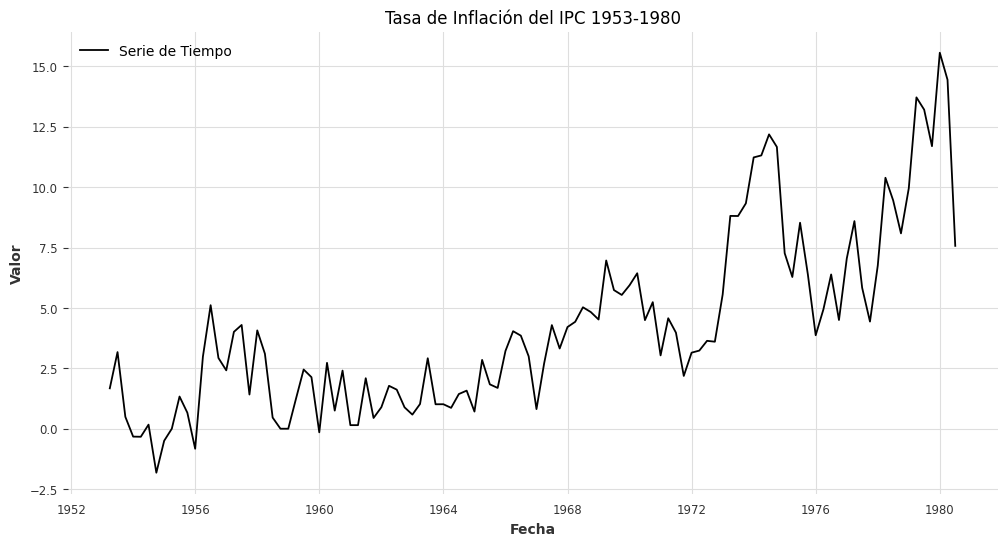

In [8]:
# Gráfica
plt.figure(figsize=(12, 6))
plt.plot( df.index, df['Series'], label='Serie de Tiempo')
plt.title('Tasa de Inflación del IPC 1953-1980')
plt.xlabel('Fecha')
plt.ylabel('Valor')
plt.legend()
plt.show()

## Pruebas de Estacionariedad, No linealidad y dependencias a largo plazo

Pruebas de estacionariedad, linealidad (esta se hace en $\texttt{R}$) y dependencias a largo plazo.

In [9]:
# Prueba de estacionariedad para series de tiempo: Prueba ADF
from statsmodels.tsa.stattools import adfuller

# Función para realizar la prueba ADF
def prueba_adf(serie):
    resultado_adf = adfuller(serie, autolag='AIC')
    print('Resultados de la prueba ADF para la serie dada:')
    print('Estadística ADF:', resultado_adf[0])
    print('Valor crítico (1%):', resultado_adf[4]['1%'])
    print('Valor crítico (5%):', resultado_adf[4]['5%'])
    print('Valor crítico (10%):', resultado_adf[4]['10%'])
    print('Valor p:', resultado_adf[1])
    # Verifica si la serie es estacionaria
    if resultado_adf[1] <= 0.05:
        print("La serie es estacionaria (rechazamos la hipótesis nula).")
    else:
        print("La serie no es estacionaria (no hay suficiente evidencia para rechazar la hipótesis nula).")

# Realiza la prueba ADF
prueba_adf(df)

# Interpretación: Si ADF es menor que los críticos o si el pvalue suficientemente bajo => Estacionaria

Resultados de la prueba ADF para la serie dada:
Estadística ADF: -0.20774601589278013
Valor crítico (1%): -3.498198082189098
Valor crítico (5%): -2.891208211860468
Valor crítico (10%): -2.5825959973472097
Valor p: 0.9375919925699775
La serie no es estacionaria (no hay suficiente evidencia para rechazar la hipótesis nula).


In [10]:
# Prueba de estacionariedad (trend-stationary) para series de tiempo: Prueba KPSS
from statsmodels.tsa.stattools import kpss

# Función para realizar la prueba KPSS e indicar si la serie es trend-stationary o no
def prueba_kpss(serie):
    resultado_kpss = kpss(serie)
    print('Resultados de la prueba KPSS para estacionariedad:')
    print('Estadística KPSS:', resultado_kpss[0])
    print('Valor crítico (1%):', resultado_kpss[3]['1%'])
    print('Valor crítico (5%):', resultado_kpss[3]['5%'])
    print('Valor crítico (10%):', resultado_kpss[3]['10%'])
    print('Valor p:', resultado_kpss[1])

    # Verifica si la serie es no lineal
    if resultado_kpss[1] <= 0.05:
        print("La serie es no trend-stationary (rechazamos la hipótesis nula).")
    else:
        print("La serie es trend-stationary (no hay suficiente evidencia para rechazar la hipótesis nula).")


# Realiza la prueba KPSS e indica si la serie es lineal o no
prueba_kpss(df)

# Interpretación: Si KPSS es mayor que los críticos o si el pvalue suficientemente bajo => No lineal ??? Duda

Resultados de la prueba KPSS para estacionariedad:
Estadística KPSS: 1.459779394260322
Valor crítico (1%): 0.739
Valor crítico (5%): 0.463
Valor crítico (10%): 0.347
Valor p: 0.01
La serie es no trend-stationary (rechazamos la hipótesis nula).


<ipython-input-10-0bfd172b2923>:6: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  resultado_kpss = kpss(serie)


In [11]:
# Prueba de linealidad para series de tiempo: Prueba de Terasvirta

#Revisar código en R

In [12]:
!pip install hurst

In [13]:
# Prueba de Dependencia a largo plazo para series de tiempo: Exponente de Hurst

from hurst import compute_Hc

# Función para realizar la prueba del exponente de Hurst
def prueba_hurst(serie):
    H, c, data = compute_Hc(serie, kind='random_walk', simplified=True)

    # Imprimir el valor del exponente de Hurst
    print("H={:.4f}, c={:.4f}".format(H,c))

    # Verifica si la serie es dependiente de largo plazo
    print('Resultados de la prueba del exponente de Hurst para dependencia de largo plazo:')
    if H > 0.5:
        print("La serie es dependiente de largo plazo.")
    else:
        print("La serie no es dependiente de largo plazo.")


# Realiza la prueba del exponente de Hurst e indica si la serie es dependiente de largo plazo
prueba_hurst(df)

# Interpretación: A value H in the range 0.5–1 indicates a time series with long-term positive autocorrelation

H=0.5181, c=0.7602
Resultados de la prueba del exponente de Hurst para dependencia de largo plazo:
La serie es dependiente de largo plazo.


## Entrenamiento y predicción con W-transformer

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Tiempo de corrida: 82.10760129300002 seconds
Número de componentes: 4


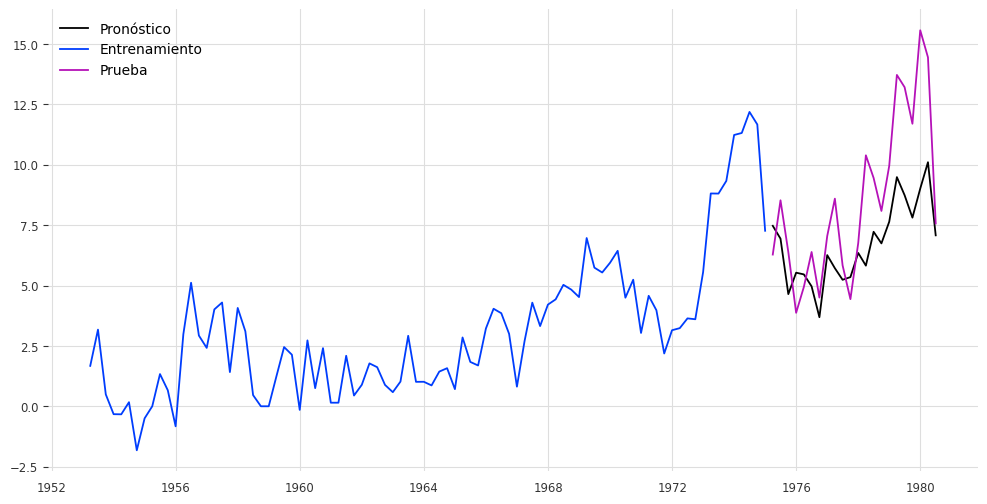

{'MAE': 2.225446362828667,
 'RMSE': 2.7882188559454484,
 'MASE': 1.8802205757384782,
 'MAPE': 23.824943404198322,
 'sMAPE': 26.701710971501434}

In [20]:
prediccion, metricas = w_transformer(df, nforecast = 22)
metricas

Comparaciones con preprocesamiento de la serie

a) Con datos escalados

b) Diferenciando antes de aplicar

c) Realizando una descomposición de la serie y aplicandolo a la componente

## W-Transformer con escalamiento

In [27]:
from darts.dataprocessing.transformers import Scaler
scaler = Scaler()

def w_transformer_scaled(df, nforecast = 26):
    # Se escalan los datos
    ts_series = TimeSeries.from_dataframe(df)
    nb_time = df.shape[0] # Número total de elementos de la serie
    train_scaled = scaler.fit_transform(ts_series[:nb_time-nforecast])
    series_scaled  = scaler.transform(ts_series )

    # Se crea un data frame
    df_scaled = pd.DataFrame({'Date': series_scaled.time_index, 'Series': series_scaled.values().flatten()})
    df_scaled.set_index('Date', inplace=True)

    start_time = time.perf_counter()
    series = df['Series']
    ncomp = int(np.log(len(series)))  # Número de componentes
    wt = modwt(series, 'haar', ncomp )  # Retorna las señales obtenidas mediante maximal overlap discrete wavelet transform (MODWT)

    # Inicialización
    seriesList = []
    train = []
    test = []
    nb_time = len(series) # Número total de elementos de la serie
    nb_test = int(nb_time*0.2) # Número de elementos de prueba

    # Para cada señal:
    for i in range(len(wt)):
        wt_df = TimeSeries.from_dataframe(pd.DataFrame(wt[i]))
        seriesList.append(wt_df)
        wt_df_train = wt_df[:nb_time-nforecast]
        train.append(wt_df_train)
        wt_df_test = wt_df[nb_time-nforecast:]
        test.append(wt_df_test)

    prediction = []
    # A cada componente se le ajusta un transformer y se estiman las predicciones
    for i in range(len(train)):
        transformers = TransformerModel(
                input_chunk_length=12,
                output_chunk_length=1,
                batch_size=32,
                n_epochs=200,
                model_name="transformer"+str(i),
                nr_epochs_val_period=10,
                #d_model=16,
                #nhead=8,
                d_model=64,
                nhead=32,
                num_encoder_layers=2,
                num_decoder_layers=2,
                dim_feedforward=128,
                dropout=0.1,
                activation="relu",
                random_state=42,
                save_checkpoints=True,
                force_reset=True,
                pl_trainer_kwargs = {"accelerator": "gpu"}
        )

        # Entrenamiento del transformer
        transformers.fit(series = train[i], verbose=True)
        #print('seriesList = ',seriesList[i])
        #print('nb-time-nforecast = ',nb_time-nforecast)


        # Predicción histórica del transformer
        pred_series = transformers.historical_forecasts(seriesList[i],
                                                                start = nb_time-nforecast,
                                                                retrain=False,
                                                                verbose=True,
                                                                )
        prediction.append(pred_series)

    # Se guarda en un data frame las predicciones de todas las componentes
    prediction_tmp = prediction[0].pd_dataframe()
    for i in range(1,len(prediction)):
        prediction_tmp[i] = prediction[i].pd_dataframe()
    # Se aplica la inversa de la transformada para obtener a partir de las componentes la predicción
    res = imodwt(prediction_tmp.transpose().to_numpy(),'haar')
    index_train =df.index[:nb_time-nforecast]
    index = df.index[nb_time-nforecast:]
    train_reindex = pd.DataFrame(series[:nb_time-nforecast].reset_index(drop=True)).set_index(index_train)
    test_reindex = pd.DataFrame(series[nb_time-nforecast:].reset_index(drop=True)).set_index(index)
    res_pred = pd.DataFrame(res).set_index(index)

    # Deshace la estandarización
    res_pred = scaler.inverse_transform(TimeSeries.from_dataframe(res_pred)).pd_dataframe()

    # Deshace la estandarización para las partes de entrenamiento y prueba
    train_reindex = scaler.inverse_transform(TimeSeries.from_dataframe(train_reindex)).pd_dataframe()
    test_reindex = scaler.inverse_transform(TimeSeries.from_dataframe(test_reindex)).pd_dataframe()


    current_time = time.perf_counter()

    print("Tiempo de corrida: {} seconds".format(str(current_time-start_time)))
    print("Número de componentes: {}".format(str(ncomp)))

    # Gráfica del pronóstico
    plt.figure(figsize=(12, 6))
    plt.plot(res_pred.index, res_pred.iloc[:,0], label='Pronóstico')
    plt.plot(train_reindex.index, train_reindex.iloc[:,0], label='Entrenamiento')
    plt.plot(test_reindex.index, test_reindex.iloc[:,0], label='Prueba')
    plt.legend()
    plt.show()

    y_pred = TimeSeries.from_dataframe(res_pred)
    ts_train = TimeSeries.from_dataframe(train_reindex)
    ts_test = TimeSeries.from_dataframe(test_reindex)


    return res_pred, {
        "MAE": mae(actual_series = ts_test, pred_series = y_pred),
        "RMSE":  rmse(actual_series = ts_test, pred_series = y_pred),
        "MASE": mase(actual_series = ts_test, pred_series = y_pred, insample=ts_train),
        "MAPE": mape(actual_series = ts_test, pred_series = y_pred),
        "sMAPE": smape(actual_series = ts_test, pred_series = y_pred)
    }



/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:282: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name                | Type                | Params
------------------------------------------------------------
0 | criterion           | MSELoss          

Training: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=200` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: |          | 0/? [00:00<?, ?it/s]

Tiempo de corrida: 79.90640875600002 seconds
Número de componentes: 4


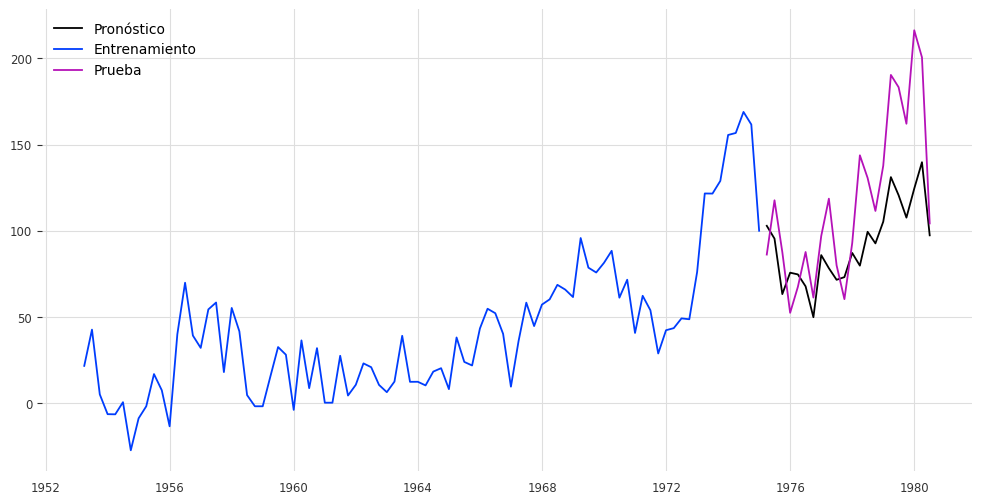

{'MAE': 31.176278096866803,
 'RMSE': 39.06015795293979,
 'MASE': 1.8802205757384782,
 'MAPE': 24.231462462368746,
 'sMAPE': 27.17427427415624}

In [28]:
prediccion, metricas = w_transformer_scaled(df, nforecast = 22)
metricas


 AirPassengers Dataset

In [ ]:
from darts.datasets import AirPassengersDataset
from darts.dataprocessing.transformers import Scaler
scaler = Scaler()
nforecast = 26

# Load the AirPassengers dataset
series = AirPassengersDataset().load().astype(np.float32)
nb_time = len(series )
# Se escalan los datos
train_scaled = scaler.fit_transform(series[:nb_time-nforecast])
series_scaled = scaler.transform(series)

# Se crea un DataFrame
df_air = pd.DataFrame({'Date': series_scaled.time_index, 'Series': series_scaled.values().flatten()})
df_air.set_index('Date', inplace=True)

prediccion, metricas = w_transformer(df_air, nforecast = 26)
metricas